In [ ]:
!pip install biopython pandas numpy matplotlib seaborn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 41.7 MB/s eta 0:00:00


In [ ]:
from google.colab import files

In [ ]:
import os
import sys
from collections import Counter
from Bio import SeqIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
WINDOW = 40
STEP = 8
MOTIFS = ["UGUGU","UGUUU","GUUGU","GUGU","UGU","GUU","UUUGU","UUGU"]
MOTIF_WEIGHT = 0.15

In [ ]:
LOCAL_DIR = "/content"
OUTDIR = "/content/chikv_results"
os.makedirs(OUTDIR, exist_ok=True)


In [ ]:
def seq_to_rna(seq):
    return str(seq).upper().replace("T","U")

def count_motifs(seq, motifs):
    total = 0
    for m in motifs:
        start = 0
        while True:
            i = seq.find(m, start)
            if i == -1:
                break
            total += 1
            start = i + 1
    return total

In [ ]:
def sliding_windows(seq, window=WINDOW, step=STEP):
    n = len(seq)
    for i in range(0, n - window + 1, step):
        yield i, seq[i:i+window]

def analyze_record(rec, window=WINDOW, step=STEP):
    rna = seq_to_rna(rec.seq)
    rows = []
    for start, w in sliding_windows(rna, window, step):
        c = Counter(w)
        G = c.get('G',0)
        U = c.get('U',0)
        gu_frac = (G + U) / len(w)
        motif_c = count_motifs(w, MOTIFS)
        gu_score = gu_frac + MOTIF_WEIGHT * motif_c
        rows.append({
            "accession": rec.id,
            "length": len(rec.seq),
            "start": start,
            "end": start+len(w),
            "G": G, "U": U,
            "GU_frac": gu_frac,
            "motif_count": motif_c,
            "gu_score": gu_score
        })
    return pd.DataFrame(rows)

In [ ]:
def extract_annotations_from_record(rec):
    feats = []
    if not hasattr(rec, "features"):
        return feats
    for f in rec.features:
        if f.type in ("gene","CDS","mat_peptide","ncRNA","source"):
            name = None
            if 'gene' in f.qualifiers:
                name = f.qualifiers.get('gene')[0]
            elif 'product' in f.qualifiers:
                name = f.qualifiers.get('product')[0]
            elif 'note' in f.qualifiers:
                name = f.qualifiers.get('note')[0]
            else:
                name = f.type
            try:
                start = int(f.location.nofuzzy_start)
                end = int(f.location.nofuzzy_end)
            except Exception:
                try:
                    start = int(f.location.start)
                    end = int(f.location.end)
                except Exception:
                    continue
            feats.append((name, start, end))
    return feats


In [ ]:
print("Looking for sequence files in:", LOCAL_DIR)
files_found = sorted([f for f in os.listdir(LOCAL_DIR) if f.lower().endswith(('.fa','.fasta','.fa.gz','.fna','.gb','.gbk'))])
print("Files detected:", files_found)
if len(files_found) == 0:
    raise SystemExit("No sequence files found in LOCAL_DIR. Upload your FASTA/GenBank files to Colab and re-run.")

Looking for sequence files in: /content
Files detected: ['sequences.fasta']


In [ ]:
records = []
for fname in files_found:
    path = os.path.join(LOCAL_DIR, fname)
    # handle gzipped fasta (if any)
    if fname.lower().endswith(('.fa.gz', '.fasta.gz')):
        import gzip
        with gzip.open(path, "rt") as fh:
            recs = list(SeqIO.parse(fh, "fasta"))
            records.extend(recs)
    elif fname.lower().endswith(('.fa', '.fasta', '.fna')):
        recs = list(SeqIO.parse(path, "fasta"))
        records.extend(recs)
    elif fname.lower().endswith(('.gb', '.gbk')):
        recs = list(SeqIO.parse(path, "genbank"))
        records.extend(recs)
print("Total sequences loaded:", len(records))
if len(records) == 0:
    raise SystemExit("No valid sequences parsed. Check file formats.")

Total sequences loaded: 50


In [ ]:
for i, rec in enumerate(records):
    if not getattr(rec, "id", None) or rec.id == "<unknown id>":
        rec.id = f"seq_{i+1}"

In [ ]:
all_dfs = []
annotations_map = {}
for rec in records:
    print(f"Analyzing {rec.id} (len={len(rec.seq)}) ...")
    df = analyze_record(rec, window=WINDOW, step=STEP)
    out_csv = os.path.join(OUTDIR, f"{rec.id}_windows.csv")
    df.to_csv(out_csv, index=False)
    print("  saved:", out_csv)
    all_dfs.append(df)
    # annotations if present (GenBank)
    feats = extract_annotations_from_record(rec)
    annotations_map[rec.id] = feats
    # also save genbank if rec originally had features
    if feats:
        gb_out = os.path.join(OUTDIR, f"{rec.id}.gb")
        with open(gb_out, "w") as fh:
            SeqIO.write(rec, fh, "genbank")

Analyzing PV660466.1 (len=11824) ...
  saved: /content/chikv_results/PV660466.1_windows.csv
Analyzing PV660467.1 (len=11826) ...
  saved: /content/chikv_results/PV660467.1_windows.csv
Analyzing PV660468.1 (len=11826) ...
  saved: /content/chikv_results/PV660468.1_windows.csv
Analyzing PV660469.1 (len=11826) ...
  saved: /content/chikv_results/PV660469.1_windows.csv
Analyzing PV660470.1 (len=11826) ...
  saved: /content/chikv_results/PV660470.1_windows.csv
Analyzing PV660471.1 (len=11826) ...
  saved: /content/chikv_results/PV660471.1_windows.csv
Analyzing PX216391.1 (len=11701) ...
  saved: /content/chikv_results/PX216391.1_windows.csv
Analyzing PX216392.1 (len=11713) ...
  saved: /content/chikv_results/PX216392.1_windows.csv
Analyzing PX216393.1 (len=11713) ...
  saved: /content/chikv_results/PX216393.1_windows.csv
Analyzing PX216394.1 (len=11701) ...
  saved: /content/chikv_results/PX216394.1_windows.csv
Analyzing PV685523.1 (len=11237) ...
  saved: /content/chikv_results/PV685523.1_

In [ ]:
combined = pd.concat(all_dfs, ignore_index=True)
agg = combined.groupby("start").agg(
    gu_score_mean=("gu_score","mean"),
    gu_score_median=("gu_score","median"),
    gu_score_std=("gu_score","std"),
    GU_frac_mean=("GU_frac","mean"),
    motif_count_mean=("motif_count","mean"),
    count=("gu_score","count")
).reset_index()
agg_fn = os.path.join(OUTDIR, "aggregated_windows_by_start.csv")
agg.to_csv(agg_fn, index=False)
print("Aggregated windows saved:", agg_fn)

Aggregated windows saved: /content/chikv_results/aggregated_windows_by_start.csv


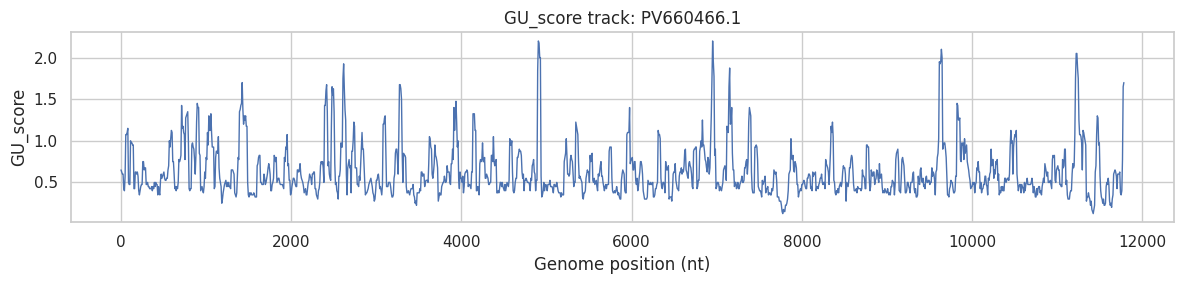

Saved example track: /content/chikv_results/example_gu_track.png


In [ ]:
sns.set(style="whitegrid")
# Example track (first genome)
example = all_dfs[0]
plt.figure(figsize=(12,3))
plt.plot(example['start'], example['gu_score'], lw=1)
plt.xlabel('Genome position (nt)')
plt.ylabel('GU_score')
plt.title(f"GU_score track: {example['accession'].iloc[0]}")
plt.tight_layout()
p1 = os.path.join(OUTDIR, "example_gu_track.png")
plt.savefig(p1, dpi=200)
plt.show()
plt.close()
print("Saved example track:", p1)


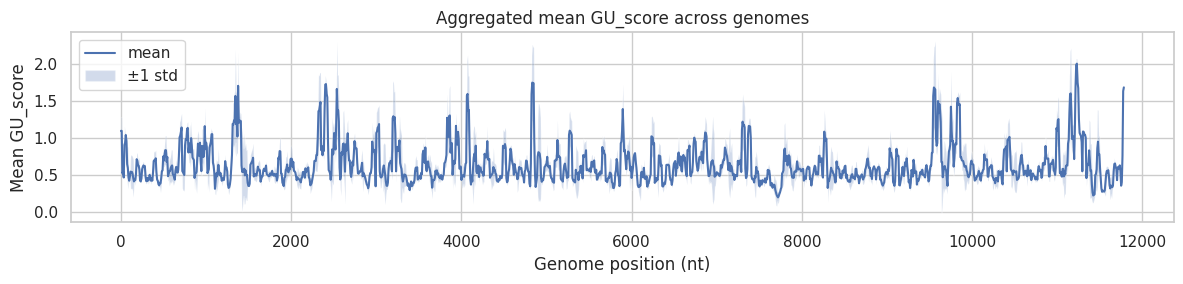

Saved aggregated track: /content/chikv_results/aggregated_gu_track.png


In [ ]:
plt.figure(figsize=(12,3))
x = agg['start']
y = agg['gu_score_mean']
yerr = agg['gu_score_std'].fillna(0)
plt.plot(x, y, label='mean')
plt.fill_between(x, y - yerr, y + yerr, alpha=0.25, label='±1 std')
plt.xlabel('Genome position (nt)')
plt.ylabel('Mean GU_score')
plt.title('Aggregated mean GU_score across genomes')
plt.legend()
plt.tight_layout()
p2 = os.path.join(OUTDIR, "aggregated_gu_track.png")
plt.savefig(p2, dpi=200)
plt.show()
plt.close()
print("Saved aggregated track:", p2)

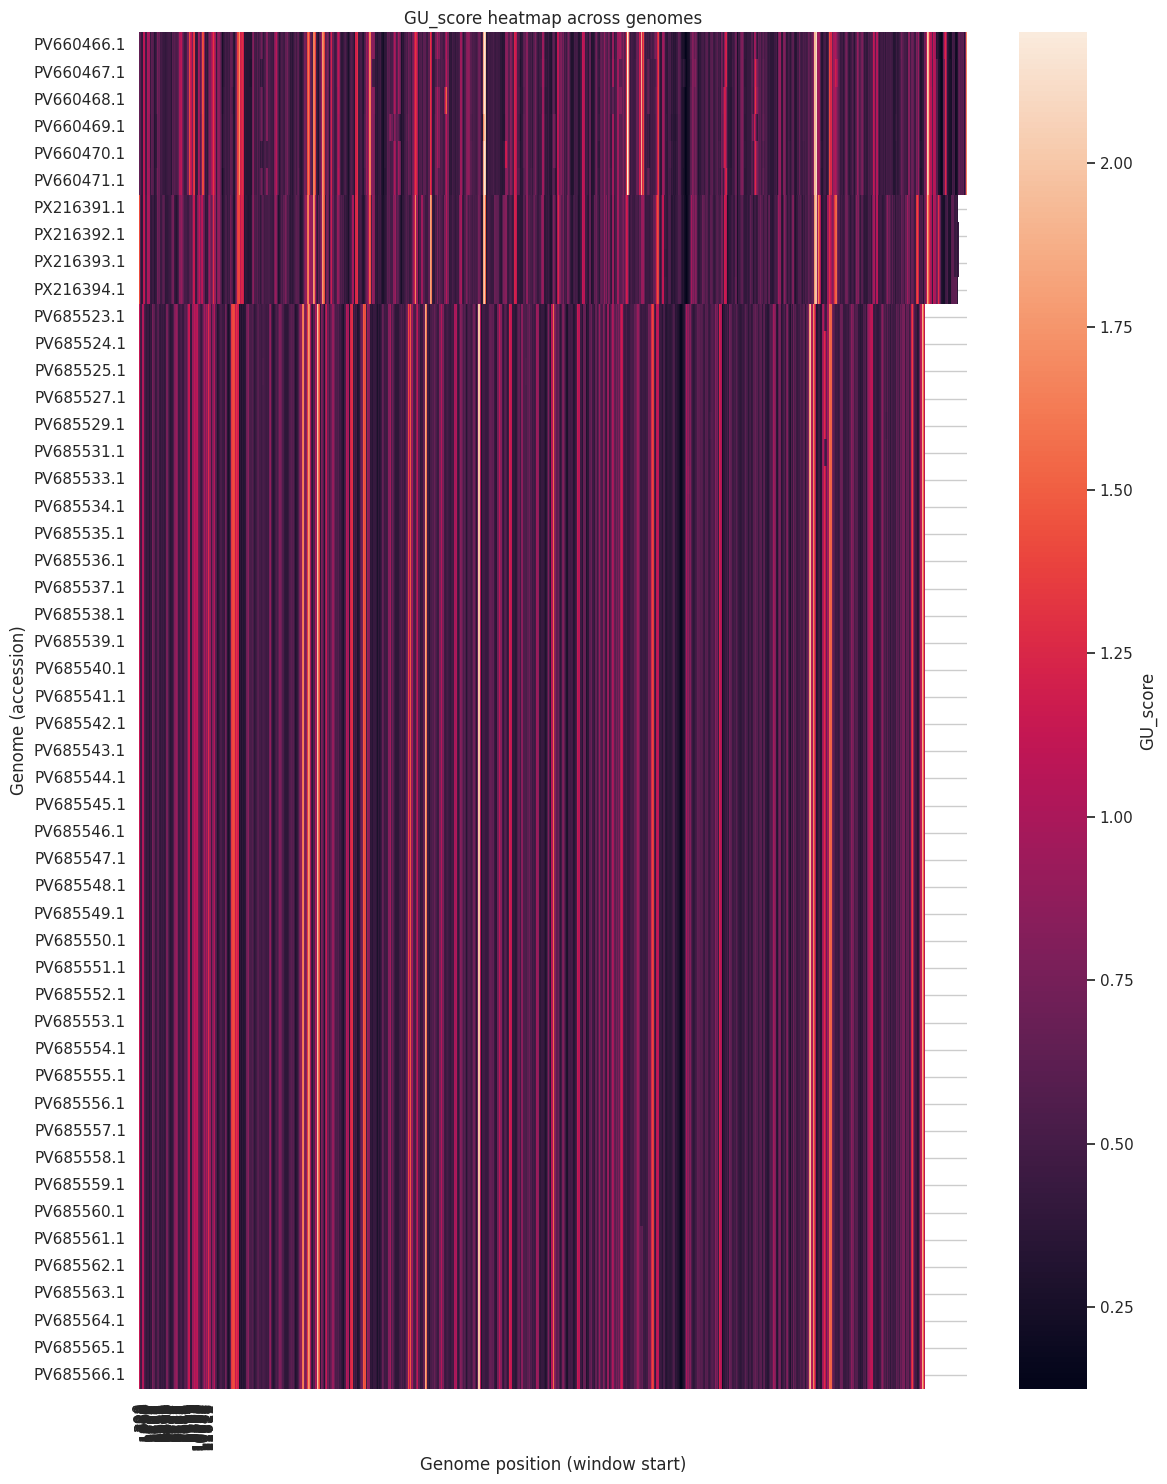

Saved heatmap: /content/chikv_results/heatmap_gu_scores.png


In [ ]:
starts = sorted(combined['start'].unique())
genome_ids = [df['accession'].iloc[0] for df in all_dfs]
mat = np.full((len(all_dfs), len(starts)), np.nan)
for i, df in enumerate(all_dfs):
    mapping = dict(zip(df['start'], df['gu_score']))
    mat[i,:] = [mapping.get(s, np.nan) for s in starts]

plt.figure(figsize=(12, max(3, len(all_dfs)*0.3)))
ax = sns.heatmap(mat, xticklabels=starts[::max(1, int(100/STEP))], yticklabels=genome_ids, cbar_kws={'label':'GU_score'})
ax.set_xlabel('Genome position (window start)')
ax.set_ylabel('Genome (accession)')
ax.set_title('GU_score heatmap across genomes')
hm = os.path.join(OUTDIR, "heatmap_gu_scores.png")
plt.tight_layout()
plt.savefig(hm, dpi=200)
plt.show()
plt.close()
print("Saved heatmap:", hm)

In [ ]:
agg_sorted = agg.sort_values("gu_score_mean", ascending=False)
topn = 15
top = agg_sorted.head(topn).copy()
first_acc = all_dfs[0]['accession'].iloc[0]
feats = annotations_map.get(first_acc, [])
def find_gene_for_window(s,e, feats):
    for name, a,b in feats:
        if (s < b) and (e > a):
            return name
    return "intergenic"
top['end'] = top['start'] + WINDOW
top['nearest_gene'] = top.apply(lambda r: find_gene_for_window(int(r['start']), int(r['end']), feats), axis=1)
top_fn = os.path.join(OUTDIR, "top_hotspots.csv")
top.to_csv(top_fn, index=False)
print("Saved top hotspots:", top_fn)
print(top.head(10).to_string(index=False))


Saved top hotspots: /content/chikv_results/top_hotspots.csv
 start  gu_score_mean  gu_score_median  gu_score_std  GU_frac_mean  motif_count_mean  count   end nearest_gene
 11232          2.000            2.050      0.064550         0.710              8.60     10 11272   intergenic
 11224          1.980            2.050      0.090370         0.690              8.60     10 11264   intergenic
 11240          1.745            1.875      0.167829         0.665              7.20     10 11280   intergenic
  4832          1.744            2.000      0.517316         0.484              8.40     50  4872   intergenic
  4848          1.735            1.975      0.484873         0.475              8.40     50  4888   intergenic
  4840          1.725            1.975      0.505076         0.465              8.40     50  4880   intergenic
  2408          1.724            1.750      0.053681         0.554              7.80     50  2448   intergenic
  2400          1.717            1.775      0.121789

In [ ]:
summary = {
    "num_genomes": len(all_dfs),
    "window": WINDOW,
    "step": STEP,
    "motif_count_types": len(MOTIFS),
    "top_hotspot_start": int(top.iloc[0]['start']) if not top.empty else None,
    "top_hotspot_gene": top.iloc[0]['nearest_gene'] if not top.empty else None
}
with open(os.path.join(OUTDIR, "summary.txt"), "w") as fh:
    for k,v in summary.items():
        fh.write(f"{k}: {v}\n")
print("Summary written to:", os.path.join(OUTDIR, "summary.txt"))
print("All results saved to:", OUTDIR)

Summary written to: /content/chikv_results/summary.txt
All results saved to: /content/chikv_results
